# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 01.10.2023

Мягкий дедлайн: 23:59MSK 15.10.2023

Жесткий дедлайн: 23:59MSK 20.10.2023

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Итогова оценка считается как
$$
min(task_1, task_2)*0.8 + max(task_1, task_2)*0.2
$$

где task_1 и task_2 - оценки за первое и второе заданиее соответсвенно.
Также, за домашнее задание выставляется 0, если не сделано нулевое или третье задание.
### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2023-10-14 23:37:44--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.txt.zip’

data.txt.zip            [             <=>    ] 201.24M  79.3MB/s    in 2.5s    

2023-10-14 23:37:46 (79.3 MB/s) - ‘data.txt.zip’ saved [211011981]



In [3]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [4]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

# Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Для выполнения данного задания (и всех последующих) предобработайте данные.

1. Зафиксируйте random_seed везде где только возможно. Вам предоставлена функция для этого, однако вы можете дополнить ее своими дополнениями
2. Обучите StandertScaler и предобработайте ваши данные. В следующих заданиях можете использовать другой scaler или вообще отказаться от него


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
import os

def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    # Add smth here if you need...

In [7]:
set_random_seed(42)

In [8]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

model = Ridge()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

rmse_for_model = mean_squared_error(y_test, y_pred, squared=False)
rmse_for_model

9.510160820470436

Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем

In [9]:
constant_pred = np.full(y_test.shape[0], y_train.mean())

In [10]:
best_rmse_metric = mean_squared_error(y_test, constant_pred, squared=False)
best_rmse_metric

10.85246390513634

# Задание 1. (максимум 10 баллов)

Закрепите свои знания о том, как pytorch работает с обратным распространением ошибки, проделав следующие шаги:

1. Создайте модель линейной регрессии, которая будет состоять только из одного Linear слоя.
2. Напишите цикл обучения вашей линейной регрессии. В нем реализуйте подсчет функции потерь, сделайте шаг градиентного спуска. Запрещено использовать готовые оптимизаторы и loss-функции из библиотеки pytorch. Для подсчета градиента воспользуйтесь методом backward.
3. Запустите обучение на 10 эпохах, после каждой проверяйте значение целевой метрики на тестовой выборке.
4. Выведите на экран графики метрики и значения функции потерь на тестовой и обучающей выборке.

В данном задании нет цели побить какой-то порог по метрике. Ваша задача - убедиться в том, что ваш рукописный цикл обучения работает. Для ускорения вычислений и обучения модели можете брать только срез данных, а не весь датасет.

In [11]:
class LinearRegression(nn.Module):
    def __init__(self, in_features, out_size):
        super().__init__()
        self.linear = nn.Linear(in_features, out_size)

    def forward(self, x):
        return self.linear(x)

In [12]:
def loss_function(y_pred, target):
    return (target - y_pred).square().mean()

In [13]:
model = LinearRegression(in_features=X_train.shape[1], out_size=1)

In [14]:
for name, param in model.named_parameters():
    print(name, param)

linear.weight Parameter containing:
tensor([[ 0.0806,  0.0875, -0.0247,  0.0968, -0.0231,  0.0213, -0.0513,  0.0619,
          0.0929, -0.0773,  0.0916,  0.0197,  0.0779,  0.0143,  0.0508, -0.0149,
          0.0813,  0.0156, -0.0492,  0.0269, -0.0486, -0.0124, -0.0428,  0.0699,
         -0.0832, -0.0486, -0.0298, -0.0634,  0.0099, -0.1041,  0.0952, -0.0895,
          0.0814,  0.0175, -0.0342,  0.0651,  0.0164,  0.0852,  0.0115, -0.0332,
          0.0283, -0.0286,  0.0444,  0.0941,  0.0609, -0.0461,  0.0608,  0.0189,
          0.0535, -0.0642, -0.1043, -0.0407, -0.0809,  0.0865,  0.0304,  0.0437,
          0.0333, -0.0018,  0.0825, -0.0749,  0.0066, -0.0719,  0.0325, -0.0363,
          0.0323, -0.0220,  0.0874, -0.0625, -0.0629, -0.0629,  0.0948,  0.0351,
          0.1014, -0.0870, -0.1046, -0.0825, -0.0709,  0.0427,  0.0377,  0.0876,
         -0.0544, -0.0719,  0.0559, -0.0426,  0.0640, -0.0250,  0.0603, -0.0819,
         -0.0532,  0.0321]], requires_grad=True)
linear.bias Parameter co

In [15]:
X_train_sample = torch.tensor(X_train[:10000], dtype=torch.float32)
y_train_sample = torch.tensor(y_train[:10000], dtype=torch.float32)

In [16]:
N_EPOCH = 10
LR = 0.1

train_loss, test_loss = [], []
train_metric, test_metric = [], []


for epoch in range(N_EPOCH):

    y_pred = model(X_train_sample)

    loss = loss_function(y_pred.squeeze(), y_train_sample)
    loss.backward()

    train_loss.append(loss.item())

    metric = mean_squared_error(y_pred.squeeze().numpy(force=True), y_train_sample.numpy(), squared=False)
    train_metric.append(metric)

    with torch.no_grad():
        y_pred = model(torch.tensor(X_test, dtype=torch.float32))
        loss = loss_function(y_pred.squeeze(), torch.tensor(y_test, dtype=torch.float32))
        test_loss.append(loss.item())
        metric = mean_squared_error(y_pred.squeeze().numpy(), y_test, squared=False)
        test_metric.append(metric)

    model.linear.bias = nn.Parameter(model.linear.bias - LR * model.linear.bias.grad)
    model.linear.weight = nn.Parameter(model.linear.weight - LR * model.linear.weight.grad)

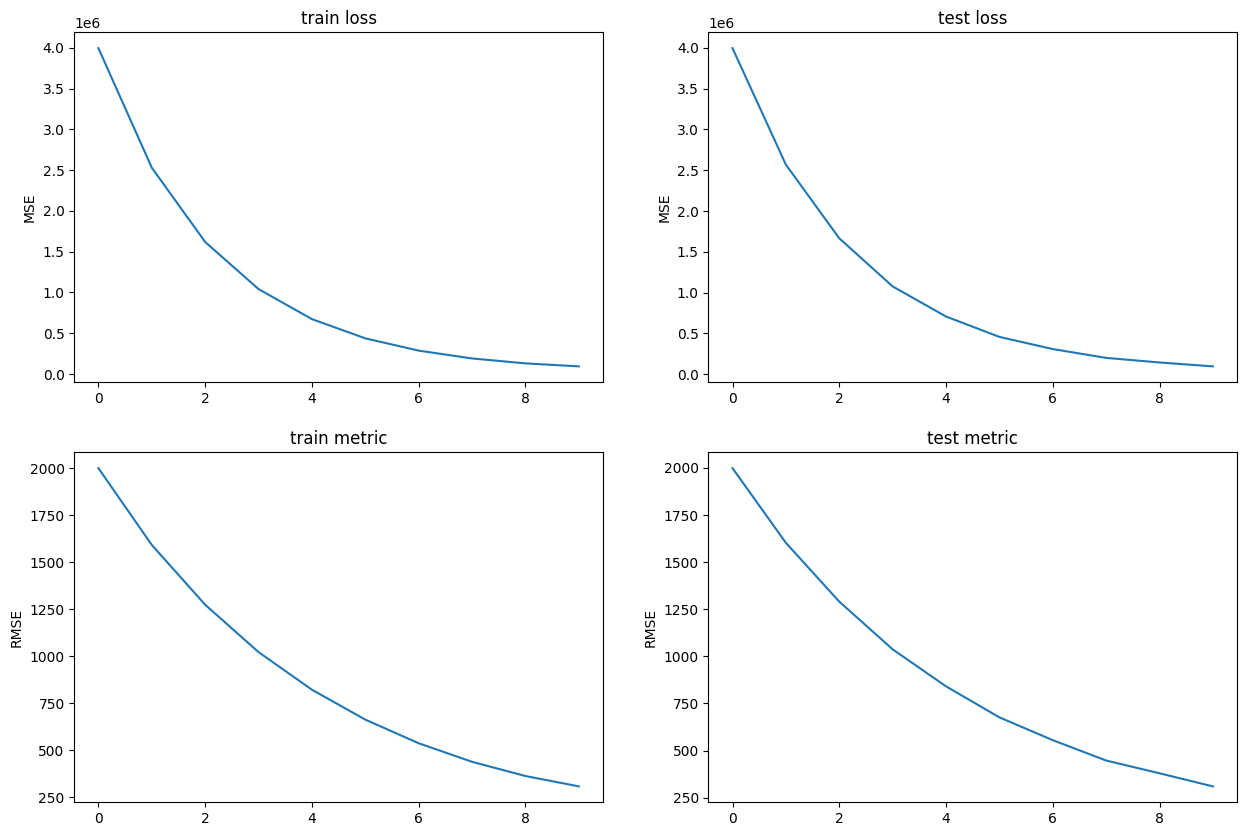

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

ax[0, 0].plot(train_loss)
ax[0, 0].set_title('train loss')
ax[0, 0].set_ylabel('MSE')

ax[0, 1].plot(test_loss)
ax[0, 1].set_title('test loss')
ax[0, 1].set_ylabel('MSE')

ax[1, 0].plot(train_metric)
ax[1, 0].set_title('train metric')
ax[1, 0].set_ylabel('RMSE')

ax[1, 1].plot(test_metric)
ax[1, 1].set_title('test metric')
ax[1, 1].set_ylabel('RMSE')

plt.show()

# Задание 2. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из предыдущего задания.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться сигнатурами функций, которые приведены ниже. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [18]:
def plot_losses(train_loss, test_loss, train_metric, test_metric):

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].plot(train_loss, label='train')
    ax[0].plot(test_loss, label='test')
    ax[0].legend()
    ax[0].set_title('Loss MSE (target scaled)')

    ax[1].plot(train_metric, label='train')
    ax[1].plot(test_metric, label='test')
    ax[1].legend()
    ax[1].set_title('Metric RMSE (target unscaled)')


    plt.show()

In [19]:
def train(model,
          train_loader,
          val_loader,
          criterion,
          num_epochs=100,
          scheduler=None,
          grad_norm=1.0):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_loss, test_loss = [], []
    train_metric, test_metric = [], []
    
    
    # Train loop
    for epoch in range(1, num_epochs + 1):
        print('Current epoch: ', epoch)

        batch_loss, batch_metric = 0.0, 0.0
        model.train()
        for batch_number, (items, labels) in enumerate(tqdm(train_loader, desc='Training'), start=1):
            optimizer.zero_grad()

            items = items.to(device)
            labels = labels.to(device)

            y_pred = model(items)

            assert y_pred.size() == labels.size()
            if batch_number == 1:
                assert y_pred.size()[0] == train_loader.batch_size

            loss = criterion(y_pred, labels)
            loss.backward()

            nn.utils.clip_grad_norm_(model.parameters(), grad_norm)
            optimizer.step()

            batch_loss += loss.item()

            y_pred = scaler.inverse_transform(y_pred.numpy(force=True))
            labels = scaler.inverse_transform(labels.numpy(force=True))

            assert y_pred.shape == labels.shape
            if batch_number == 1:
                assert y_pred.shape[0] == train_loader.batch_size

            metric = mean_squared_error(labels, y_pred, squared=False)
            batch_metric += metric

        if scheduler:
            scheduler.step(batch_metric)

        train_loss.append(batch_loss / batch_number)
        train_metric.append(batch_metric / batch_number)
        
        
        # Evaluation
        model.eval()
        for items, labels in val_loader:
            items = items.to(device)
            labels = labels.to(device)

            y_pred = model(items)
            assert y_pred.size() == labels.size()
            assert y_pred.size()[0] == val_loader.batch_size
            loss = criterion(y_pred, labels)

            y_pred = scaler.inverse_transform(y_pred.numpy(force=True))
            labels = scaler.inverse_transform(labels.numpy(force=True))

            assert y_pred.shape == labels.shape
            assert y_pred.shape[0] == val_loader.batch_size
            metric = mean_squared_error(labels, y_pred, squared=False)

        test_loss.append(loss.item())
        test_metric.append(metric)

        # Logging
        clear_output()
        plot_losses(train_loss, test_loss, train_metric, test_metric)
        print('best loss', min(test_loss), 'on epoch number', test_loss.index(min(test_loss)) + 1)
        print('best metric', min(test_metric), 'on epoch number', test_metric.index(min(test_metric)) + 1)

In [20]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


class SongsSet(Dataset):

    def __init__(self, x, y):
        self.x = torch.Tensor(x)
        self.y = torch.Tensor(y)
        self.n_samples = self.x.size()[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.n_samples

In [21]:
scaler = StandardScaler()

y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.reshape(-1, 1))

## Experiments

В третьем задание будет краткое описание всех экспериментов. Здесь сохранил более подробные результаты на всякий случай

### Experiment 1

In [22]:
set_random_seed(42)

In [23]:
class SongNet(nn.Module):
    def __init__(self, in_features, hidden, out_size=1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, hidden),
            nn.ReLU(),
            nn.Linear(hidden, out_size)
        )

    def forward(self, X):
       return self.model(X)

In [25]:
BATCH_SIZE = 64
LR = 0.01

train_set = SongsSet(X_train, y_train_scaled)
train_loader = DataLoader(train_set, shuffle=True, batch_size=BATCH_SIZE)

test_set = SongsSet(X_test, y_test_scaled)
test_loader = DataLoader(test_set, shuffle=False, batch_size=len(test_set))

model = SongNet(in_features=train_set.x.size()[1], hidden=train_set.x.size()[1])

optimizer = torch.optim.SGD(model.parameters(), lr=LR)
criterion = torch.nn.MSELoss()

print(model)

SongNet(
  (model): Sequential(
    (0): Linear(in_features=90, out_features=90, bias=True)
    (1): ReLU()
    (2): Linear(in_features=90, out_features=1, bias=True)
  )
)


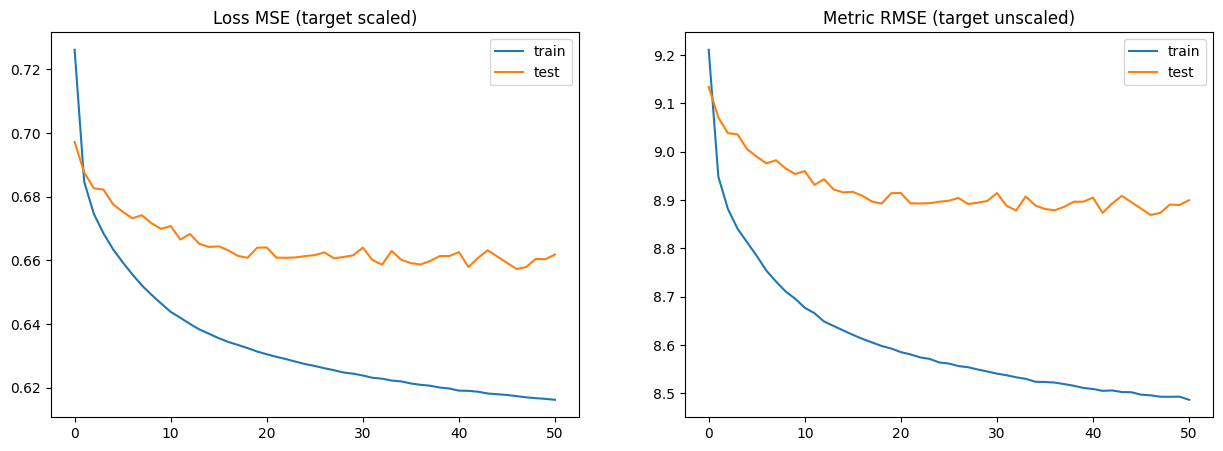

best loss 0.6573063731193542 on epoch number 47
best metric 8.869344 on epoch number 47
Current epoch:  52


Training:   0%|          | 0/7246 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [25]:
train(model, train_loader, test_loader, criterion)

### Experiment 2

In [42]:
set_random_seed(42)

In [43]:
class SongNet(nn.Module):
    def __init__(self, in_features, hidden, out_size=1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, out_size)
        )

    def forward(self, X):
       return self.model(X)

In [44]:
BATCH_SIZE = 64
LR = 0.01

train_set = SongsSet(X_train, y_train_scaled)
train_loader = DataLoader(train_set, shuffle=True, batch_size=BATCH_SIZE)

test_set = SongsSet(X_test, y_test_scaled)
test_loader = DataLoader(test_set, shuffle=False, batch_size=len(test_set))

model = SongNet(in_features=train_set.x.size()[1], hidden=train_set.x.size()[1] // 2)

optimizer = torch.optim.SGD(model.parameters(), lr=LR)
criterion = torch.nn.MSELoss()

print(model)

SongNet(
  (model): Sequential(
    (0): Linear(in_features=90, out_features=45, bias=True)
    (1): ReLU()
    (2): Linear(in_features=45, out_features=45, bias=True)
    (3): ReLU()
    (4): Linear(in_features=45, out_features=45, bias=True)
    (5): ReLU()
    (6): Linear(in_features=45, out_features=1, bias=True)
  )
)


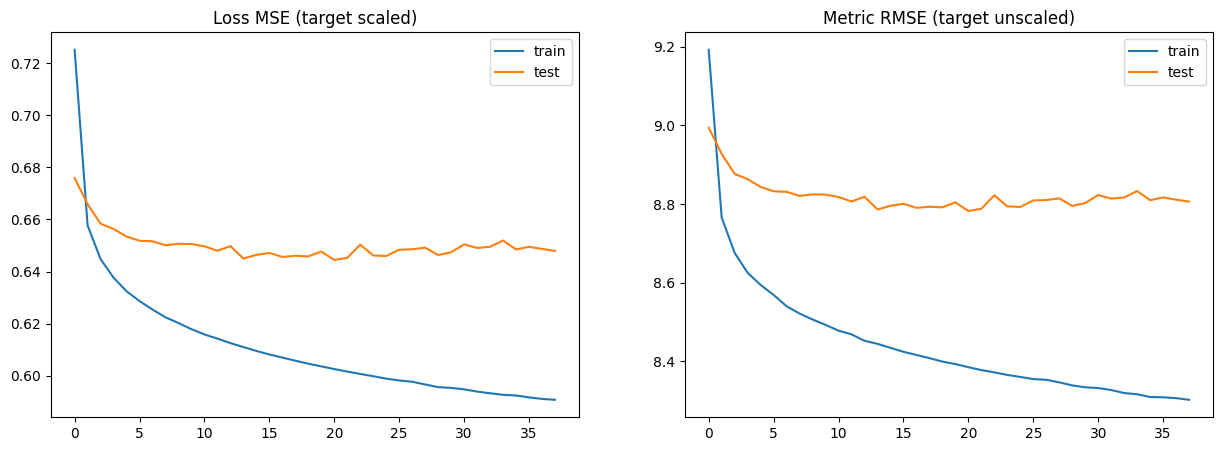

best loss 0.6444458961486816 on epoch number 21
best metric 8.78215 on epoch number 21
Current epoch:  39


Training:   0%|          | 0/7246 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [29]:
train(model, train_loader, test_loader, criterion)

### Experiment 3 (change optimizer to AdamW + add sheduler)

In [22]:
set_random_seed(42)

In [23]:
class SongNet(nn.Module):
    def __init__(self, in_features, hidden, out_size=1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, out_size)
        )

    def forward(self, X):
       return self.model(X)

In [24]:
BATCH_SIZE = 64
LR = 0.001
THRESHOLD = 3

train_set = SongsSet(X_train, y_train_scaled)
train_loader = DataLoader(train_set, shuffle=True, batch_size=BATCH_SIZE)

test_set = SongsSet(X_test, y_test_scaled)
test_loader = DataLoader(test_set, shuffle=False, batch_size=len(test_set))

model = SongNet(in_features=train_set.x.size()[1], hidden=train_set.x.size()[1] // 2)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', threshold=THRESHOLD)
criterion = torch.nn.MSELoss()

print(model)

SongNet(
  (model): Sequential(
    (0): Linear(in_features=90, out_features=45, bias=True)
    (1): ReLU()
    (2): Linear(in_features=45, out_features=45, bias=True)
    (3): ReLU()
    (4): Linear(in_features=45, out_features=45, bias=True)
    (5): ReLU()
    (6): Linear(in_features=45, out_features=1, bias=True)
  )
)


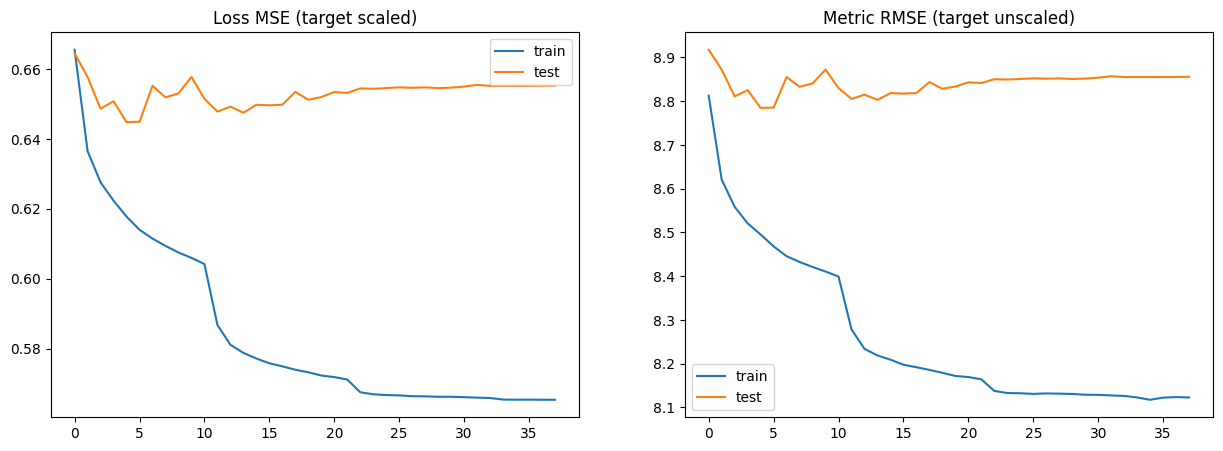

best loss 0.6448138356208801 on epoch number 5
best metric 8.784657 on epoch number 5
Current epoch:  39


Training:   0%|          | 0/7246 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [25]:
train(model, train_loader, test_loader, criterion, scheduler=scheduler)

### Experiment 4 (add batch normalization)

In [26]:
set_random_seed(42)

In [27]:
class SongNet(nn.Module):
    def __init__(self, in_features, hidden, out_size=1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),

            nn.Linear(hidden, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),

            nn.Linear(hidden, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),

            nn.Linear(hidden, out_size)
        )

    def forward(self, X):
       return self.model(X)

In [28]:
BATCH_SIZE = 64
LR = 0.001
THRESHOLD = 3

train_set = SongsSet(X_train, y_train_scaled)
train_loader = DataLoader(train_set, shuffle=True, batch_size=BATCH_SIZE)

test_set = SongsSet(X_test, y_test_scaled)
test_loader = DataLoader(test_set, shuffle=False, batch_size=len(test_set))

model = SongNet(in_features=train_set.x.size()[1], hidden=train_set.x.size()[1] // 2)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', threshold=THRESHOLD)
criterion = torch.nn.MSELoss()

print(model)

SongNet(
  (model): Sequential(
    (0): Linear(in_features=90, out_features=45, bias=True)
    (1): BatchNorm1d(45, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=45, out_features=45, bias=True)
    (4): BatchNorm1d(45, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=45, out_features=45, bias=True)
    (7): BatchNorm1d(45, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=45, out_features=1, bias=True)
  )
)


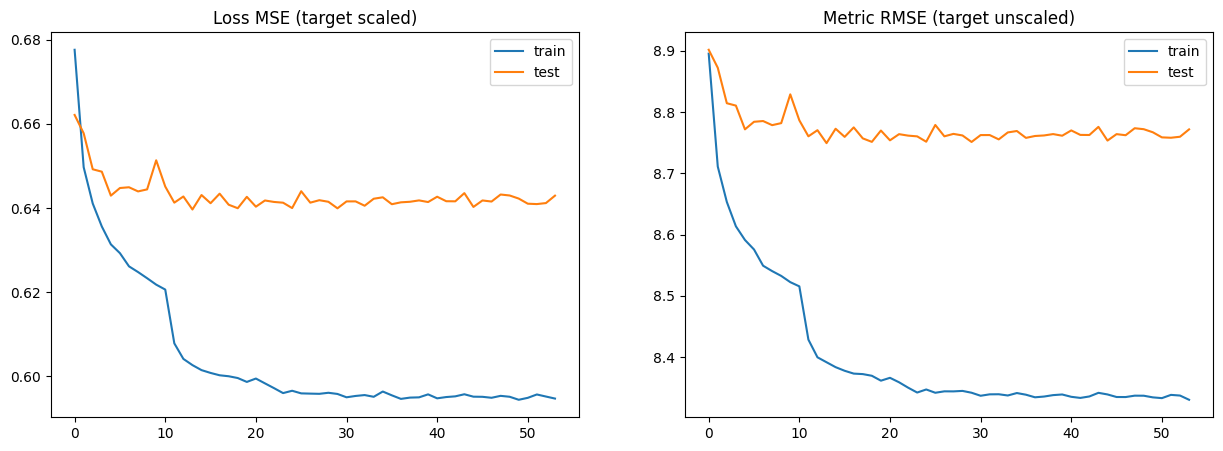

best loss 0.6396397352218628 on epoch number 14
best metric 8.74934 on epoch number 14
Current epoch:  55


Training:   0%|          | 0/7246 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [29]:
train(model, train_loader, test_loader, criterion, scheduler=scheduler)

### Experiment 5 (increase number of parameters)

In [30]:
set_random_seed(42)

In [31]:
class SongNet(nn.Module):
    def __init__(self, in_features, hidden, out_size=1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),

            nn.Linear(hidden, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),

            nn.Linear(hidden, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),

            nn.Linear(hidden, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),

            nn.Linear(hidden, hidden // 2),
            nn.BatchNorm1d(hidden // 2),
            nn.ReLU(),

            nn.Linear(hidden // 2, hidden // 2),
            nn.BatchNorm1d(hidden // 2),
            nn.ReLU(),

            nn.Linear(hidden // 2, hidden // 4),
            nn.BatchNorm1d(hidden // 4),
            nn.ReLU(),

            nn.Linear(hidden // 4, out_size)
        )

    def forward(self, X):
       return self.model(X)

In [32]:
BATCH_SIZE = 64
LR = 0.001
THRESHOLD = 3

train_set = SongsSet(X_train, y_train_scaled)
train_loader = DataLoader(train_set, shuffle=True, batch_size=BATCH_SIZE)

test_set = SongsSet(X_test, y_test_scaled)
test_loader = DataLoader(test_set, shuffle=False, batch_size=len(test_set))

model = SongNet(in_features=train_set.x.size()[1], hidden=train_set.x.size()[1] * 4)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', threshold=THRESHOLD)
criterion = torch.nn.MSELoss()

print(model)

SongNet(
  (model): Sequential(
    (0): Linear(in_features=90, out_features=360, bias=True)
    (1): BatchNorm1d(360, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=360, out_features=360, bias=True)
    (4): BatchNorm1d(360, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=360, out_features=360, bias=True)
    (7): BatchNorm1d(360, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=360, out_features=360, bias=True)
    (10): BatchNorm1d(360, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Linear(in_features=360, out_features=180, bias=True)
    (13): BatchNorm1d(180, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Linear(in_features=180, out_features=180, bias=True)
    (16): BatchNorm1d(180, eps=1e-05, momentum=0.1, affine=Tr

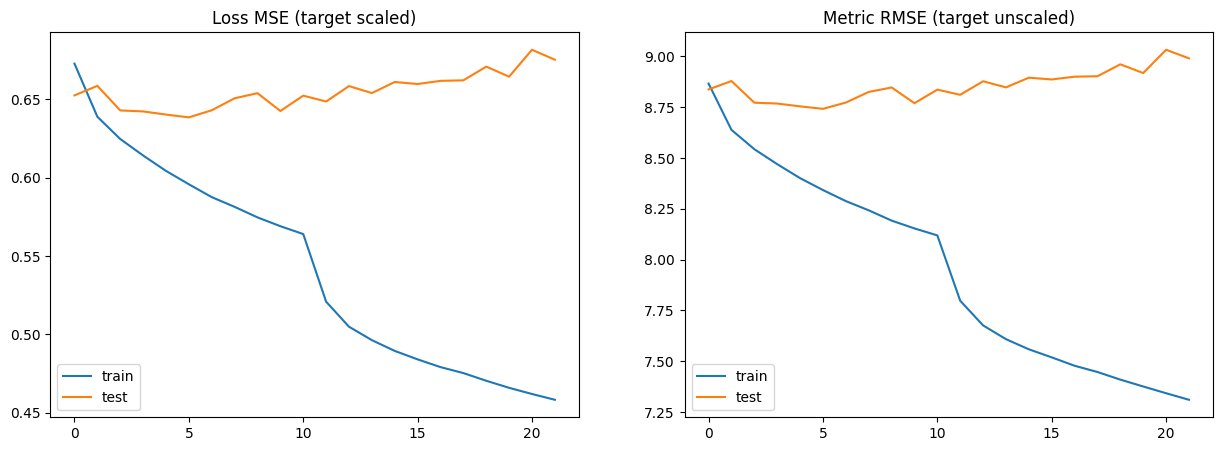

best loss 0.6385470032691956 on epoch number 6
best metric 8.741863 on epoch number 6
Current epoch:  23


Training:   0%|          | 0/7246 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [33]:
train(model, train_loader, test_loader, criterion, scheduler=scheduler)

### Experiment 6 (add dropout)

In [34]:
class SongNet(nn.Module):
    def __init__(self, in_features, hidden, out_size=1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),

            nn.Linear(hidden, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),

            nn.Linear(hidden, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),

            nn.Linear(hidden, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),

            nn.Dropout(),

            nn.Linear(hidden, hidden // 2),
            nn.BatchNorm1d(hidden // 2),
            nn.ReLU(),

            nn.Linear(hidden // 2, hidden // 2),
            nn.BatchNorm1d(hidden // 2),
            nn.ReLU(),

            nn.Linear(hidden // 2, hidden // 4),
            nn.BatchNorm1d(hidden // 4),
            nn.ReLU(),

            nn.Linear(hidden // 4, out_size)
        )

    def forward(self, X):
       return self.model(X)

In [35]:
BATCH_SIZE = 64
LR = 0.001
THRESHOLD = 3

train_set = SongsSet(X_train, y_train_scaled)
train_loader = DataLoader(train_set, shuffle=True, batch_size=BATCH_SIZE)

test_set = SongsSet(X_test, y_test_scaled)
test_loader = DataLoader(test_set, shuffle=False, batch_size=len(test_set))

model = SongNet(in_features=train_set.x.size()[1], hidden=train_set.x.size()[1] * 8)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', threshold=THRESHOLD)
criterion = torch.nn.MSELoss()

print(model)

SongNet(
  (model): Sequential(
    (0): Linear(in_features=90, out_features=720, bias=True)
    (1): BatchNorm1d(720, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=720, out_features=720, bias=True)
    (4): BatchNorm1d(720, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=720, out_features=720, bias=True)
    (7): BatchNorm1d(720, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=720, out_features=720, bias=True)
    (10): BatchNorm1d(720, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Dropout(p=0.5, inplace=False)
    (13): Linear(in_features=720, out_features=360, bias=True)
    (14): BatchNorm1d(360, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): ReLU()
    (16): Linear(in_features=360, out_features=360, bias=True)
    (17): BatchNorm1d

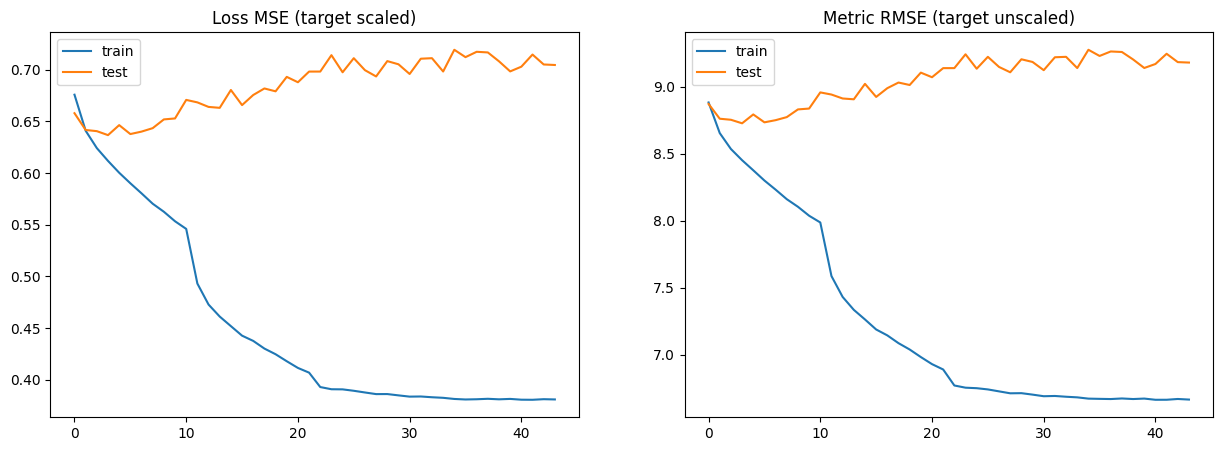

best loss 0.636599600315094 on epoch number 4
best metric 8.728523 on epoch number 4
Current epoch:  45


Training:   0%|          | 0/7246 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [36]:
set_random_seed(42)
train(model, train_loader, test_loader, criterion, scheduler=scheduler)

### Experiment 7 (Invent ResNet)

In [26]:
set_random_seed(42)

In [27]:
class SongNet(nn.Module):
    def __init__(self, in_features, hidden, out_size=1):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Linear(in_features, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),

            nn.Linear(hidden, hidden // 4),
            nn.BatchNorm1d(hidden // 4),
            nn.ReLU(),

            nn.Linear(hidden // 4, in_features),
            nn.BatchNorm1d(in_features),
            nn.ReLU(),
            )

        self.block2 = nn.Sequential(
            nn.Linear(in_features, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),

            nn.Linear(hidden, hidden // 4),
            nn.BatchNorm1d(hidden // 4),
            nn.ReLU(),

            nn.Linear(hidden // 4, in_features),
            nn.BatchNorm1d(in_features),
            nn.ReLU(),
            )

        self.block3 = nn.Sequential(
            nn.Linear(in_features, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),

            nn.Linear(hidden, hidden // 4),
            nn.BatchNorm1d(hidden // 4),
            nn.ReLU(),

            nn.Linear(hidden // 4, in_features),
            nn.BatchNorm1d(in_features),
            nn.ReLU(),
            )

        self.block4 = nn.Sequential(
            nn.Linear(in_features, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),

            nn.Linear(hidden, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),

            nn.Linear(hidden, hidden // 2),
            nn.BatchNorm1d(hidden // 2),
            nn.ReLU(),

            nn.Linear(hidden // 2, hidden // 4),
            nn.BatchNorm1d(hidden // 4),
            nn.ReLU(),

            nn.Linear(hidden // 4, hidden // 8),
            nn.BatchNorm1d(hidden // 8),
            nn.ReLU(),

            nn.Linear(hidden // 8, out_size)
            )

    def forward(self, X):
        residual1 = X
        X = self.block1(X)
        residual2 = X
        X = self.block2(X + residual1)
        residual3 = X
        X = self.block3(X + residual1 + residual2)
        return self.block4(X + residual1 + residual2 + residual3)

In [28]:
BATCH_SIZE = 64
LR = 0.001
THRESHOLD = 3

train_set = SongsSet(X_train, y_train_scaled)
train_loader = DataLoader(train_set, shuffle=True, batch_size=BATCH_SIZE)

test_set = SongsSet(X_test, y_test_scaled)
test_loader = DataLoader(test_set, shuffle=False, batch_size=len(test_set))

model = SongNet(in_features=train_set.x.size()[1], hidden=train_set.x.size()[1] * 16)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', threshold=THRESHOLD)
criterion = torch.nn.MSELoss()

print(model)

SongNet(

  (block1): Sequential(

    (0): Linear(in_features=90, out_features=1440, bias=True)

    (1): BatchNorm1d(1440, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

    (2): ReLU()

    (3): Linear(in_features=1440, out_features=360, bias=True)

    (4): BatchNorm1d(360, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

    (5): ReLU()

    (6): Linear(in_features=360, out_features=90, bias=True)

    (7): BatchNorm1d(90, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

    (8): ReLU()

  )

  (block2): Sequential(

    (0): Linear(in_features=90, out_features=1440, bias=True)

    (1): BatchNorm1d(1440, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

    (2): ReLU()

    (3): Linear(in_features=1440, out_features=360, bias=True)

    (4): BatchNorm1d(360, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

    (5): ReLU()

    (6): Linear(in_features=360, out_features=90, bias=True)

    (7): BatchNo

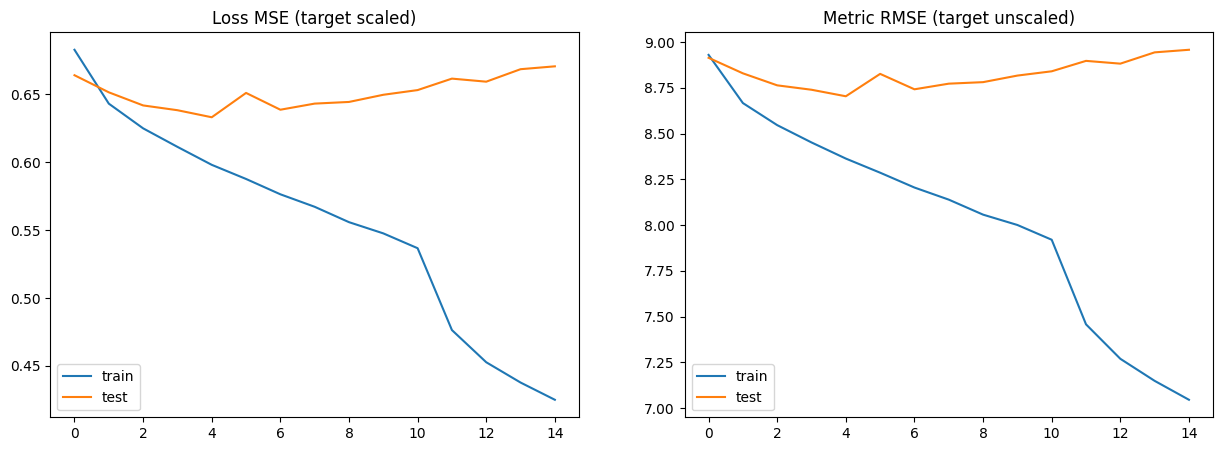

best loss 0.6330608129501343 on epoch number 5

best metric 8.704228 on epoch number 5

Current epoch:  16


Training:   0%|          | 0/7246 [00:00<?, ?it/s]

In [ ]:
train(model, train_loader, test_loader, criterion, scheduler=scheduler)

# Best model

In [37]:
set_random_seed(42)

In [38]:
class SongNet(nn.Module):
    def __init__(self, in_features, hidden, out_size=1):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Linear(in_features, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),

            nn.Linear(hidden, hidden // 4),
            nn.BatchNorm1d(hidden // 4),
            nn.ReLU(),

            nn.Linear(hidden // 4, in_features),
            nn.BatchNorm1d(in_features),
            nn.ReLU(),
            )

        self.block2 = nn.Sequential(
            nn.Linear(in_features, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),

            nn.Linear(hidden, hidden // 4),
            nn.BatchNorm1d(hidden // 4),
            nn.ReLU(),

            nn.Linear(hidden // 4, in_features),
            nn.BatchNorm1d(in_features),
            nn.ReLU(),
            )

        self.block3 = nn.Sequential(
            nn.Linear(in_features, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),

            nn.Linear(hidden, hidden // 4),
            nn.BatchNorm1d(hidden // 4),
            nn.ReLU(),

            nn.Linear(hidden // 4, in_features),
            nn.BatchNorm1d(in_features),
            nn.ReLU(),
            )

        self.block4 = nn.Sequential(
            nn.Linear(in_features, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),

            nn.Linear(hidden, hidden),
            nn.BatchNorm1d(hidden),
            nn.ReLU(),

            nn.Linear(hidden, hidden // 2),
            nn.BatchNorm1d(hidden // 2),
            nn.ReLU(),

            nn.Linear(hidden // 2, hidden // 4),
            nn.BatchNorm1d(hidden // 4),
            nn.ReLU(),

            nn.Linear(hidden // 4, hidden // 8),
            nn.BatchNorm1d(hidden // 8),
            nn.ReLU(),

            nn.Linear(hidden // 8, out_size)
        )

    def forward(self, X):
        residual1 = X
        X = self.block1(X)
        residual2 = X
        X = self.block2(X + residual1)
        residual3 = X
        X = self.block3(X + residual1 + residual2)
        return self.block4(X + residual1 + residual2 + residual3)

In [39]:
BATCH_SIZE = 64
LR = 0.001
THRESHOLD = 3
NUM_EPOCHS = 5

train_set = SongsSet(X_train, y_train_scaled)
train_loader = DataLoader(train_set, shuffle=True, batch_size=BATCH_SIZE)

test_set = SongsSet(X_test, y_test_scaled)
test_loader = DataLoader(test_set, shuffle=False, batch_size=len(test_set))

model = SongNet(in_features=train_set.x.size()[1], hidden=train_set.x.size()[1] * 16)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', threshold=THRESHOLD)
criterion = torch.nn.MSELoss()

print(model)

SongNet(
  (block1): Sequential(
    (0): Linear(in_features=90, out_features=1440, bias=True)
    (1): BatchNorm1d(1440, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1440, out_features=360, bias=True)
    (4): BatchNorm1d(360, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=360, out_features=90, bias=True)
    (7): BatchNorm1d(90, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
  )
  (block2): Sequential(
    (0): Linear(in_features=90, out_features=1440, bias=True)
    (1): BatchNorm1d(1440, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1440, out_features=360, bias=True)
    (4): BatchNorm1d(360, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=360, out_features=90, bias=True)
    (7): BatchNorm1d(90, eps=1e-05, 

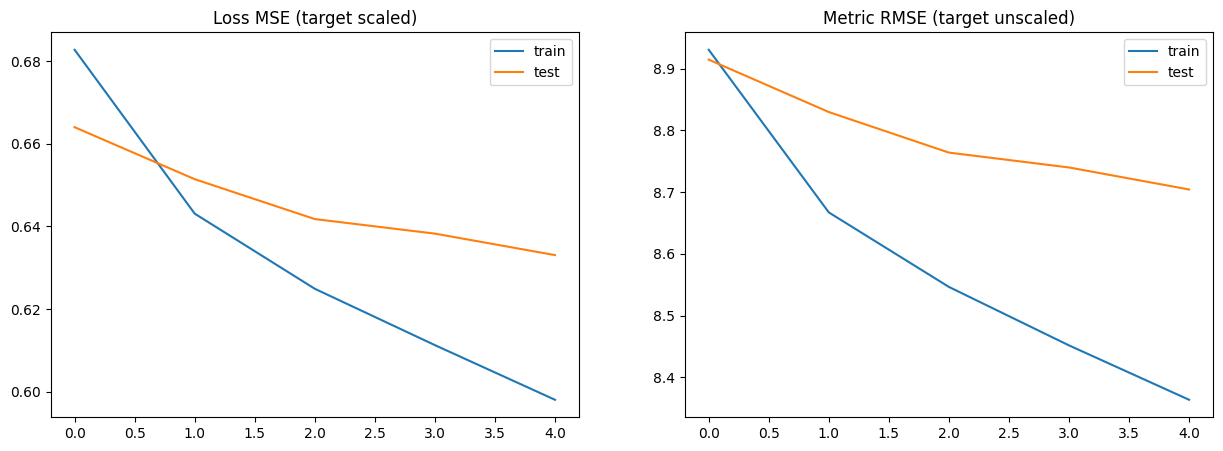

best loss 0.6330608129501343 on epoch number 5
best metric 8.704228 on epoch number 5


In [40]:
train(model, train_loader, test_loader, criterion, scheduler=scheduler, num_epochs=NUM_EPOCHS)

In [41]:
def test(model, criterion, test_loader):
    """
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - np.array with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    for items, labels in test_loader:
        items = items.to(device)
        labels = labels.to(device)
        y_pred = model(items)
        assert y_pred.size() == labels.size()
        assert y_pred.size()[0] == y_test.shape[0]
        loss = criterion(y_pred, labels).item()
        unscaled_y_pred = scaler.inverse_transform(y_pred.numpy(force=True)).reshape(1, -1)[0]
    return loss, unscaled_y_pred

In [42]:
loss, y_pred = test(model, criterion, test_loader)
loss

0.6330608129501343

In [43]:
y_pred

array([2002.9718, 2003.8954, 2000.9342, ..., 2000.2065, 2001.5775,
       1999.4861], dtype=float32)

In [44]:
y_test

array([2007, 2003, 2005, ..., 2006, 2006, 2005])

In [45]:
assert y_pred.shape == y_test.shape
mean_squared_error(y_test, y_pred, squared=False)

8.704229028105068

## Задание 3. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

1) Двухслойная сетка, в первом слое 90 * 90 (размер входа * размер выхода) + 90 (bias) параметров во втором слое 90 * 1 + 1 параметров, функция активации ReLU (используется также во всех последующих экспериментах), обучается с SGD, шаг обучения 0.01. Лучшее качество на тесте 8.87 на 47 эпохе


2) Увеличил количество слоев до четырех. В первом слое 90\*45 + 45 параметров, в втором и третьем 45 * 45 + 45 в последнем 45 * 1 + 1. Оптимайзер и шаг обучения прежние. Лучшее качество на тесте 8.78 на 21 эпохе

3) Архитектура из эксперимента 2. Изменил оптимайзер на AdamW, шаг обучения 0.001, добавил scheduler, уменьшающий шаг обучения, если лосс не уменьшается. Данная комбинация AdamW optimaizer + ReduceOnPlateu scheduler используется для обучения моделей во всех последующих экспериментах. Лучшее качество на тесте 8.78 на 5 эпохе

4) Добавил батч норм после выходов каждого линейного слоя, батч норм также применяется во всех последующих экспериментах. Лучшее качество на тесте 8.75 на 14 эпохе 

5) Увеличено число параметров. Сеть состоит из 7 слоев (если не учитывать batch norm и функцию активации после каждого линейного преобразования), в 1 слое 90 * 360 + 360 параметров, в 2-4 слое 360 * 360 + 360 параметров, в 4 слое 360 * 180 + 180 параметров, в 5 слое 180 * 180 + 180 параметров, в 6 слое 180 * 90 + 90 параметров, в последнем 90 * 1 + 1 параметров. Лучшее качество на тесте 8.74 на 6 эпохе


6) Добавил dropout(р=0.5) после четвертого полносвязного слоя. Лучшее качество на тесте 8.73 на 4 эпохе.

7) Тут всю архитектуру будет описывать немного длинно) Модель состоит из четырех блоков, блоки 1 - 3 идентичные, состоят из трёх полносвязных слоев, в них сначала размерность увеличивается в первом слое, затем в 2-3 слоях сокращается, чтобы на выходе из блока получился вектор, той же размерности, что и на входе, и можно было сделать residual connection. Последний блок более массивный, состоит из 6 слоев. Между каждыми блоками есть residual connections. Лучшее качество на тесте 8.7 на 5 эпохе.